In [1]:
import os
import tempfile
import torch
from pathlib import Path
import json
from dataclasses import fields
from datetime import datetime

from csv import writer
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.optim as optim

from data_utils.csv_dataloader import create_csv_flowpic_loader
from models.configurable_cnn import ConfigurableCNN
from training.trainer import train_model
from training.utils import set_seed, save_config_to_json
from config import Config

### Plot degradation

In [5]:
exp_path = Path('exps') / 'allot_daily_degradation_v1'
metrics_dicts = []
for dict_path in exp_path.glob('*/plots/training_history.pth'):
    metrics_dicts.append((dict_path, torch.load(dict_path)))


/tmp/ipykernel_3894227/3383856064.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics_dicts.append((dict_path, torch.load(dict_path)))


In [9]:
metrics_dicts[0]

(PosixPath('exps/allot_daily_degradation_v1/2024_09_06_09_00/plots/training_history.pth'),
 {'train_losses': [1.8027163970659235],
  'val_losses': [1.4409504414767593],
  'train_accuracies': [47.385197728857456],
  'val_accuracies': [56.98976437452772],
  'train_regular_losses': [1.802479568560412],
  'train_other_losses': {'MMD Loss': [0], 'DANN Loss': [0]}})

Experiment: 2024_09_06_09_00, Max Val Acc: 56.98976437452772, Min Val Loss: 1.4409504414767593
Experiment: 2024_09_07_09_00, Max Val Acc: 55.82415691672402, Min Val Loss: 1.4303137044289649
Experiment: 2024_09_08_09_00, Max Val Acc: 58.75502858352742, Min Val Loss: 1.3458870496550648
Experiment: 2024_09_13_09_00, Max Val Acc: 58.59131518803241, Min Val Loss: 1.3719557836384513
Experiment: 2024_09_14_09_00, Max Val Acc: 57.98199483019877, Min Val Loss: 1.400484558790909
Experiment: 2024_09_15_09_00, Max Val Acc: 56.76298001931219, Min Val Loss: 1.4290171019134714
Experiment: 2024_09_16_09_00, Max Val Acc: 56.45854657113613, Min Val Loss: 1.4244981664067362
Experiment: 2024_09_17_09_00, Max Val Acc: 53.85687732342007, Min Val Loss: 1.5742396789855673
Experiment: 2025_02_07_09_00, Max Val Acc: 45.42986425339367, Min Val Loss: 1.7984238628888023
Experiment: 2025_02_08_09_00, Max Val Acc: 46.37568199532346, Min Val Loss: 1.7113782548782304


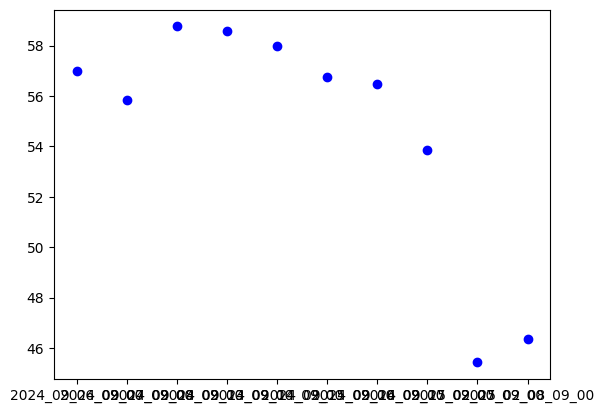

In [13]:
# ploting the val accuracy and loss over time
for dict_path, metrics_dict in metrics_dicts:
    max_val_acc = max(metrics_dict['val_accuracies'])
    min_val_loss = min(metrics_dict['val_losses'])
    exp_time = dict_path.parent.parent.name
    print(f"Experiment: {exp_time}, Max Val Acc: {max_val_acc}, Min Val Loss: {min_val_loss}")
    # exp_time = datetime.strptime(exp_time, '%Y-%m-%d_%H-%M-%S')
    
    
    plt.scatter(exp_time, max_val_acc, label='max val acc', color='blue')

In [3]:
metrics_dicts[0]

{'train_losses': [1.8027163970659235],
 'val_losses': [1.4409504414767593],
 'train_accuracies': [47.385197728857456],
 'val_accuracies': [56.98976437452772],
 'train_regular_losses': [1.802479568560412],
 'train_other_losses': {'MMD Loss': [0], 'DANN Loss': [0]}}

#### Batch normalize an existing model

In [47]:
def config_from_dict(cfg_dict):
    allowed_fields = {f.name for f in fields(Config) if f.init}
    cfg_args = {k: v for k, v in cfg_dict.items() if k in allowed_fields}
    return Config(**cfg_args)

In [3]:
exp_path = Path('/home/anatbr/students/noamshakedc/da4etc/exps/measuring_domain_shift/1_to_4/')
config_path = exp_path / 'config.json'
with open(config_path, 'r') as f:
    config_dict = json.load(f)
cfg = config_from_dict(config_dict)
    

NameError: name 'config_from_dict' is not defined

In [62]:
model = ConfigurableCNN(cfg.MODEL_PARAMS)
model.load_state_dict(torch.load(exp_path / 'weights/model_weights_epoch_20.pth'))
model = model.to(cfg.DEVICE)

/tmp/ipykernel_670770/3809115204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(exp_path / 'weights/model_weights_epoch_20.pth'))


In [63]:
def get_df_from_csvs(domain_idx, chunk_start, chunk_end, label_whitelist):
    dfs = []
    for i in range(chunk_start, chunk_end):
        chunk_path = os.path.join('data', 'allot_small_csvs', f'chunks_domain_{domain_idx}', f'chunk_{i:03}.csv')
        df = pd.read_csv(chunk_path)
        df = df[df['appId'].isin(label_whitelist)]
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

label_whitelist = [386,  497,  998,  171,  485, 2613,  340,  373,  561,  967,  436, 1088,
        961,  682,  521,  964, 1450, 1448,  965, 42][:4]
apps_id_df = pd.read_csv('data/app_id_mapping.csv', index_col=0)
apps_id_df = apps_id_df[apps_id_df.index.isin(label_whitelist)]
label_mapping = {row['names']: i for i, row in apps_id_df.reset_index().iterrows()}
label_indices_mapping = {label_index: new_label_index for
                         new_label_index, (label_index, row)
                         in enumerate(apps_id_df.iterrows())
                         if label_index in label_whitelist}


test_df_domain_4 = get_df_from_csvs(4, 70, 100, label_whitelist)
test_loader = create_csv_flowpic_loader([test_df_domain_4], batch_size=cfg.BATCH_SIZE, num_workers=0,
                                        shuffle=True, resolution=cfg.RESOLUTION,
                                        label_mapping=label_indices_mapping, log_t_axis=False) 


100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


In [65]:
from training.trainer import batch_norm_adaptation, validate

val_loss, val_acc, all_labels, all_predictions = validate(model, test_loader, nn.CrossEntropyLoss(), 'cuda')


In [67]:
batch_norm_adaptation(model, test_loader, device='cuda')

In [68]:
val_loss_new, val_acc_new, all_labels_new, all_predictions_new = validate(model, test_loader, nn.CrossEntropyLoss(), 'cuda')

In [69]:
print(f'Validation loss before adaptation: {val_loss}, after adaptation: {val_loss_new}')
print(f'Validation accuracy before adaptation: {val_acc}, after adaptation: {val_acc_new}')

Validation loss before adaptation: 0.35556050886061735, after adaptation: 0.35901972760221257
Validation accuracy before adaptation: 91.8362426463497, after adaptation: 91.8362426463497


/tmp/ipykernel_1477347/4191722206.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_history_dict = torch.load(exp_path / 'plots' / 'training_history.pth')


93.88240588934967

#### Measuring class distribution shift

In [34]:
def get_df_from_csvs(domain_idx, chunk_start, chunk_end, label_whitelist=None):
    dfs = []
    for i in range(chunk_start, chunk_end):
        chunk_path = os.path.join('data', 'allot_small_csvs', f'chunks_domain_{domain_idx}', f'chunk_{i:03}.csv')
        df = pd.read_csv(chunk_path)
        if label_whitelist is not None:
            df = df[df['appId'].isin(label_whitelist)]
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [60]:
label_whitelist = [386,  497,  998,  171,  485, 2613,  340,  373,  561,  967,  436, 1088,
        961,  682,  521,  964, 1450, 1448,  965, 42][:10]

train_df_domain_1 = get_df_from_csvs(1, 0, 70, label_whitelist)
train_df_domain_2 = get_df_from_csvs(2, 0, 70, label_whitelist)
train_df_domain_3 = get_df_from_csvs(3, 0, 70, label_whitelist)
train_df_domain_4 = get_df_from_csvs(4, 0, 70, label_whitelist)

In [1]:
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

def compare_class_distributions(df1, df2, column='appId'):
    """
    Compare the class distribution of a specific column between two DataFrames.
    Returns TVD, KL, JSD.
    """
    dist1 = df1[column].value_counts(normalize=True).sort_index()
    dist2 = df2[column].value_counts(normalize=True).sort_index()

    all_keys = sorted(set(dist1.index).union(dist2.index))
    dist1 = dist1.reindex(all_keys, fill_value=0)
    dist2 = dist2.reindex(all_keys, fill_value=0)

    epsilon = 1e-10
    dist1_safe = dist1 + epsilon
    dist2_safe = dist2 + epsilon

    tvd = 0.5 * sum(abs(dist1 - dist2))
    kl_div = sum(distance.rel_entr(dist1_safe, dist2_safe))
    jsd = distance.jensenshannon(dist1, dist2)

    return tvd, kl_div, jsd

# Input DataFrames
domains = [train_df_domain_1, train_df_domain_2, train_df_domain_3, train_df_domain_4]
times = ['2024.09.06-09', '2024.09.12-17', '2025.02.08-12', '2025.03.09-15']

# Collect distance values
tvd_list, kl_list, jsd_list = [], [], []
for df in domains:
    tvd, kl, jsd = compare_class_distributions(df, train_df_domain_1, column='appId')
    tvd_list.append(tvd)
    kl_list.append(kl)
    jsd_list.append(jsd)

# --- Plot TVD ---
plt.figure(figsize=(6, 4))
plt.plot(times, tvd_list, marker='o')
plt.title('Total Variation Distance (vs 2024.09.06-09)')
plt.xlabel('Time Period')
plt.ylabel('TVD')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot KL Divergence ---
plt.figure(figsize=(6, 4))
plt.plot(times, kl_list, marker='o')
plt.title('KL Divergence (vs 2024.09.06-09)')
plt.xlabel('Time Period')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Jensen-Shannon Distance ---
plt.figure(figsize=(6, 4))
plt.plot(times, jsd_list, marker='o')
plt.title('Jensen-Shannon Distance (vs 2024.09.06-09)')
plt.xlabel('Time Period')
plt.ylabel('JS Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'train_df_domain_1' is not defined

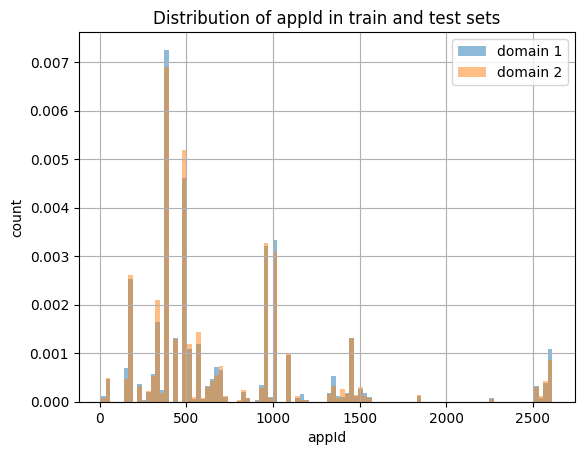

In [46]:
train_df_domain_1['appId'].hist(bins=100, alpha=0.5, label='domain 1', density=True)
train_df_domain_2['appId'].hist(bins=100, alpha=0.5, label='domain 2', density=True)
# train_df_domain_3['appId'].hist(bins=100, alpha=0.5, label='domain 3', density=True)
# train_df_domain_4['appId'].hist(bins=100, alpha=0.5, label='domain 4', density=True)
plt.legend()
plt.xlabel('appId')
plt.ylabel('count')
plt.title('Distribution of appId in train and test sets')
plt.show()

#### Validating that the app mapping is the same

In [20]:
def diff_dicts(*dicts):
    all_keys = set().union(*dicts)
    results = {}

    for key in all_keys:
        values = [d.get(key, '<Missing>') for d in dicts]
        n_results = sum(1 for v in np.unique(values) if v != '<Missing>')
        if n_results > 1:
            results[key] = values

    if results:
        print("Differences between dictionaries:")
        for key, vals in results.items():
            print(f"  Key '{key}':", end=' ')
            print(', '.join(f"dict{i+1}={val}" for i, val in enumerate(vals)))
    else:
        print("No differences found!")


In [21]:
apps_id_df = pd.read_csv('data/app_id_mapping.csv', index_col=0)
label_mapping = {row['names']: i for i, row in apps_id_df.iterrows()}


In [ ]:
mappings_path = Path('/home/anatbr/dataset/Allot/app_ids_mappings')
dicts = []
for mapping_file in mappings_path.glob('*.csv'):
    print(f"Processing {mapping_file.name}")
    current_id_df = pd.read_csv(mapping_file, index_col=0)
    current_label_mapping = {row['names']: i for i, row in current_id_df.iterrows()}
    dicts.append(current_label_mapping)

total_mapping = label_mapping
for d in dicts:
    total_mapping.update(d)

Processing ver02 - Location 01 - 2024.09.06-09_AppIds.csv
Processing ver02 - Location 01 - 2024.09.12-17_AppIds.csv
Processing ver02 - Location 01 - 2025.02.08-12_AppIds.csv
Processing ver02 - Location 01 - 2025.03.09-15_AppIds.csv
No differences found!


In [32]:
total_mapping
# Save the total mapping to a CSV file
total_mapping_df = pd.DataFrame(list(total_mapping.items()), columns=['names', 'appId'])
total_mapping_df.set_index('appId', inplace=True)
total_mapping_df.to_csv('data/app_id_mapping_1.csv')

In [ ]:
diff_dicts(*dicts, total_mapping)

No differences found!


#### Plotting results over time

In [ ]:
import matplotlib.pyplot as plt

# Data
times = ['2024.09.06-09', '2024.09.12-17', '2025.02.08-12', '2025.03.09-15']
accuracies = [97.5, 98, 94.5, 93]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(times, accuracies, marker='o', linestyle='-', linewidth=2)

# Labeling
plt.title('Accuracy per Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim([90, 100])

# Display
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Dividing csv to chunks

In [13]:
import re
def extract_numbers(x):
    if isinstance(x, str):
        # If x is a string, extract numbers
        return list(map(int, re.findall(r'\d+', x)))
    elif isinstance(x, list):
        return x
    else:
        return []    
    
lists = df['ppi-ps'].transform(extract_numbers)

In [5]:
ls /home/anatbr/dataset/Allot/full_csvs/

'ver02 - Location 01 - 2024.09.06-09.csv'
'ver02 - Location 01 - 2024.09.12-17.csv'
'ver02 - Location 01 - 2025.02.08-12.csv'*
'ver02 - Location 01 - 2025.03.09-15.csv'*


In [ ]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

columns = ['timeSec1970', 'timeMs', 'appId', 'ipAddrClient', 'ipAddrServer',
           'portClient', 'portServer', 'protocol', 'ppiLen', 'ppi-pdt',
           'ppi-pd', 'ppi-ps', 'ppi-paux']

input_path = Path('/home/anatbr/dataset/Allot/full_csvs/ver02 - Location 01 - 2024.09.06-09.csv')
output_dir = Path('/home/anatbr/dataset/Allot/allot_hourly_chunks/domain_0')
output_dir.mkdir(parents=True, exist_ok=True)

chunk_size = 200_000
hourly_buffers = {}

reader = pd.read_csv(input_path, names=columns, header=None, chunksize=chunk_size, low_memory=False, skiprows=1)

for chunk in tqdm(reader, desc="Processing chunks", total=7e8 // chunk_size):
    chunk['absoluteTime'] = pd.to_datetime(chunk['timeSec1970'], unit='s')
    chunk['hour'] = chunk['absoluteTime'].dt.floor('H')

    # Group the chunk by hour
    grouped = chunk.groupby('hour')

    hours_in_chunk = list(grouped.groups.keys())

    for hour in hours_in_chunk[:-1]:  # process all *complete* hours
        group = grouped.get_group(hour)
        if hour in hourly_buffers:
            hourly_buffers[hour] = pd.concat([hourly_buffers[hour], group], ignore_index=True)
        else:
            hourly_buffers[hour] = group

        # Write to disk and remove from buffer
        hour_str = hour.strftime('%Y-%m-%d_%H-%M')
        output_file = output_dir / f"chunk_{hour_str}.csv"
        hourly_buffers[hour].to_csv(output_file, index=False)
        del hourly_buffers[hour]

    # Handle the last hour in the chunk (may be incomplete)
    last_hour = hours_in_chunk[-1]
    group = grouped.get_group(last_hour)
    if last_hour in hourly_buffers:
        hourly_buffers[last_hour] = pd.concat([hourly_buffers[last_hour], group], ignore_index=True)
    else:
        hourly_buffers[last_hour] = group

# After all chunks, write any remaining buffered hour
for hour, df in hourly_buffers.items():
    hour_str = hour.strftime('%Y-%m-%d_%H-%M')
    output_file = output_dir / f"chunk_{hour_str}.csv"
    df.to_csv(output_file, index=False)


Processing chunks:   2%|▏         | 173/7000.0 [09:21<6:09:31,  3.25s/it] 


KeyboardInterrupt: 

In [4]:
columns = ['timeSec1970', 'timeMs', 'appId', 'ipAddrClient', 'ipAddrServer',
           'portClient', 'portServer', 'protocol', 'ppiLen', 'ppi-pdt',
           'ppi-pd', 'ppi-ps', 'ppi-paux']
n_rows_per_ds = 1e4
path = Path('/home/anatbr/dataset/Allot/ETraffic2/ver02 - Location 01 - 2025.03.09-15.csv')

ranges = []
for i in trange(200):
    df = pd.read_csv(path, nrows=n_rows_per_ds, skiprows=int(n_rows_per_ds * (i + 1)))
    df.columns = columns
    df['absoluteTime'] = pd.to_datetime(df['timeSec1970'], unit='s')
    assert df.absoluteTime.is_monotonic_increasing
    df.to_csv(f'data/allot_small_csvs/chunks_domain_4/chunk_{i:03d}.csv', index=False)
    # print(df.absoluteTime.min(), df.absoluteTime.max())
    ranges.append((df.absoluteTime.min(), df.absoluteTime.max()))

100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


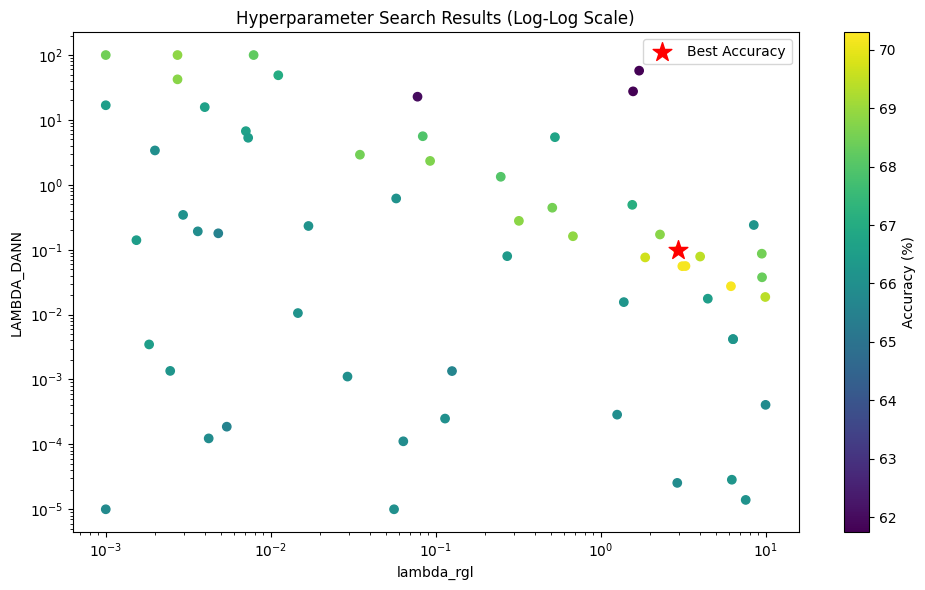

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Read the data file
file_path = "allot_dann_bsearch_v7.txt"  # Update this path if needed
with open(file_path, 'r') as f:
    lines = f.readlines()

# Parse the lines
lambda_rgl_vals = []
lambda_dann_vals = []
accuracies = []

pattern = re.compile(
    r"lambda_rgl=([-.\d]+), LAMBDA_DANN=([-.\d]+) --> Accuracy: ([\d.]+)"
)

for line in lines:
    match = pattern.search(line)
    if match:
        lambda_rgl = float(match.group(1))
        lambda_dann = float(match.group(2))
        accuracy = float(match.group(3))
        lambda_rgl_vals.append(lambda_rgl)
        lambda_dann_vals.append(lambda_dann)
        accuracies.append(accuracy)

# Convert to numpy arrays
lambda_rgl_vals = np.array(lambda_rgl_vals)
lambda_dann_vals = np.array(lambda_dann_vals)
accuracies = np.array(accuracies)

# Convert log values back to linear scale
lambda_rgl_linear = 10 ** lambda_rgl_vals
lambda_dann_linear = 10 ** lambda_dann_vals

# Identify the best point
best_idx = np.argmax(accuracies)

# Plotting
plt.figure(figsize=(10, 6))
sc = plt.scatter(lambda_rgl_linear, lambda_dann_linear, c=accuracies,
                 cmap='viridis')
plt.colorbar(sc, label='Accuracy (%)')
plt.scatter(lambda_rgl_linear[best_idx], lambda_dann_linear[best_idx],
            color='red', marker='*', s=200, label='Best Accuracy')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda_rgl')
plt.ylabel('LAMBDA_DANN')
plt.title('Hyperparameter Search Results (Log-Log Scale)')
# plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig('tmp.png')
plt.show()


In [ ]:
[
'WhatsApp Transfer', 'iTunes', 'Instagram', 'TLS with Encrypted Client Hello', 'Google Search', 'Telegram', 'Facebook', 'WhatsApp', 'iCloud', 'GoogleServices', 'Computing sites', 'Banners', 'Google Play', 'YouTube Browsing', 'Advertisements', 'Generic CDN', 'Analytics', 'HTTPS', 'Tik Tok', 'AppleServices'
]


In [ ]:
results = {}
exp_dir = Path('exps/allot_dann_bsearch_v5')
for train_log_file in exp_dir.glob('*/plots/training_history.pth'):
    train_log = torch.load(train_log_file, weights_only=False)
    max_accuracy = np.max(train_log['val_accuracies'])
    
    json_path = train_log_file.parent.parent / 'config.json'
    with open(json_path, 'r') as f:
        config_dict = json.load(f)
    lambda_rgl = config_dict['MODEL_PARAMS']['lambda_rgl']
    lambda_dann = config_dict['LAMBDA_DANN']
    results[(lambda_rgl, lambda_dann)] = max_accuracy
    

In [14]:
times = []
val_accs = []
exp_dir = Path('exps/allot_daily_degradation_v4')
for train_log_file in exp_dir.glob('*/plots/training_history.pth'):
    train_log = torch.load(train_log_file, weights_only=False)
    max_accuracy = np.max(train_log['val_accuracies'])
    datetime = datetime.strptime(train_log_file.parent.parent.name, '%Y_%m_%d_%H_%M')
    times.append(datetime)
    val_accs.append(max_accuracy)


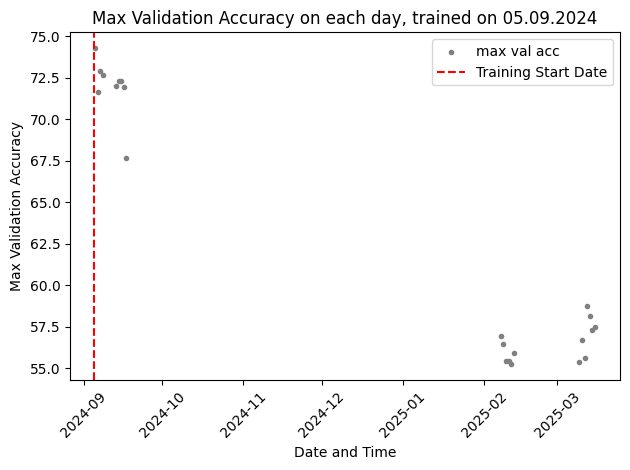

In [16]:
plt.scatter(times, val_accs, label='max val acc', color='grey', marker='.')
    
plt.axvline(datetime.strptime('2024_09_05_00_00', '%Y_%m_%d_%H_%M'), color='red', linestyle='--', label='Training Start Date')
plt.title('Max Validation Accuracy on each day, trained on 05.09.2024')
plt.xlabel('Date and Time')
plt.ylabel('Max Validation Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

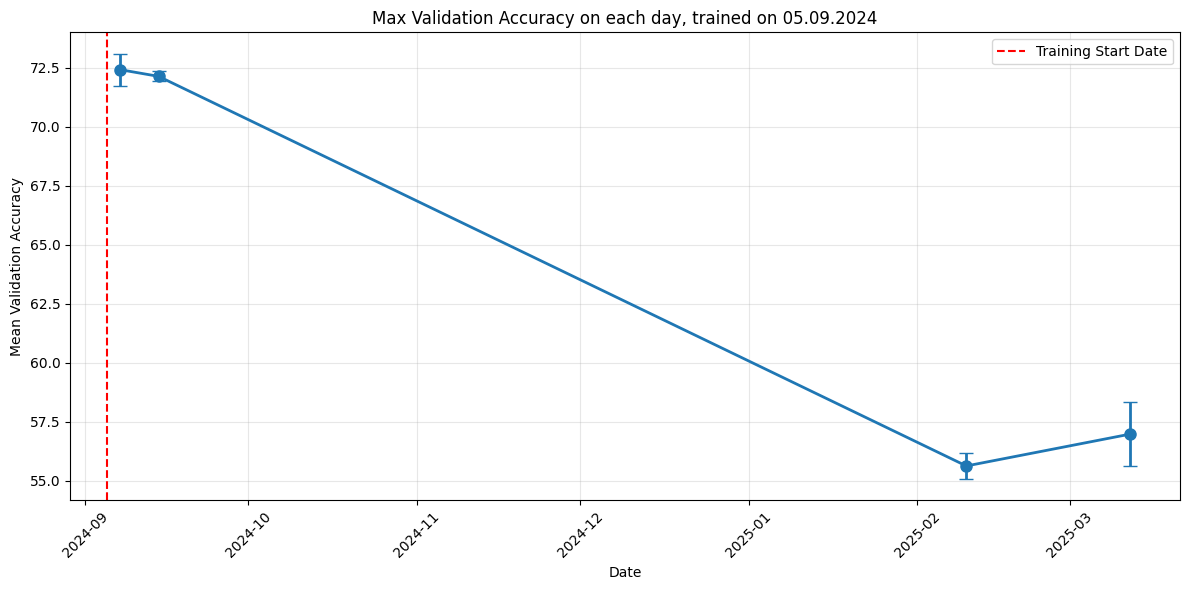

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Convert to DataFrame
df = pd.DataFrame({'time': times, 'val_acc': val_accs})

# Define period ranges
period_ranges = [
   (datetime(2024, 9, 6), datetime(2024, 9, 9)),
   (datetime(2024, 9, 12), datetime(2024, 9, 17)),
   (datetime(2025, 2, 8), datetime(2025, 2, 12)),
   (datetime(2025, 3, 9), datetime(2025, 3, 15))
]

# Calculate stats for each period
period_midpoints = []
means = []
stds = []

for start, end in period_ranges:
   period_data = df[(df['time'] >= start) & (df['time'] <= end)]['val_acc']
   if len(period_data) > 0:
       period_midpoints.append(start + (end - start) / 2)
       means.append(period_data.mean())
       stds.append(period_data.std())

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(period_midpoints, means, yerr=stds, fmt='o-', capsize=5, 
           markersize=8, linewidth=2)
plt.axvline(datetime(2024, 9, 5), color='red', linestyle='--', label='Training Start Date')
plt.title('Max Validation Accuracy on each day, trained on 05.09.2024')
plt.xlabel('Date')
plt.ylabel('Mean Validation Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
from datetime import datetime, timedelta
from training.utils import set_seed, save_config_to_json, group_chunks_by_interval


cfg = Config()
parent = Path("/home/anatbr/dataset/Allot/allot_hourly_chunks")
interval = timedelta(days=1)
start_date = datetime(2024, 9, 5, 9)

grouped = group_chunks_by_interval(parent, interval, start_date=start_date)

print(f"Number of groups: {len(grouped)}")
all_groups = list(grouped.items())

train_dfs_path = grouped[start_date]
test_groups = [(g, grouped[g]) for g in grouped] # if g != start_date
print(f"number of test groups: {len(test_groups)}")


Number of groups: 23
number of test groups: 23


In [5]:
# for g in test_groups:
#     print(f"Group {g[0]}: {len(g[1])} chunks")
set_seed(cfg.SEED)

label_whitelist = cfg.LABEL_WHITELIST
apps_id_df = pd.read_csv('data/app_id_mapping.csv', index_col=0)
# apps_id_df = pd.read_csv('/home/anatbr/students/noamshakedc/da4etc/data/app_id_mapping.csv', index_col=0)
apps_id_df = apps_id_df[apps_id_df.index.isin(label_whitelist)]
label_mapping = {row['names']: i for i, row in apps_id_df.reset_index().iterrows()}
label_indices_mapping = {label_index: new_label_index for
                        new_label_index, (label_index, row)
                        in enumerate(apps_id_df.iterrows())
                        if label_index in label_whitelist}

num_classes = len(label_mapping)
   
test_name, test_dfs_path = test_groups[1]
test_loader = create_csv_flowpic_loader(test_dfs_path, batch_size=cfg.BATCH_SIZE, num_workers=0,
                                        shuffle=False, resolution=cfg.RESOLUTION, sample_frac=cfg.SAMPLE_FRAC_FROM_CSVS,
                                        label_mapping=label_indices_mapping, log_t_axis=False)

train_loader = create_csv_flowpic_loader(train_dfs_path, batch_size=cfg.BATCH_SIZE, num_workers=0,
                                        shuffle=True, resolution=cfg.RESOLUTION, sample_frac=cfg.SAMPLE_FRAC_FROM_CSVS,
                                        label_mapping=label_indices_mapping, log_t_axis=False) 


In [6]:
len(train_loader.dataset), len(test_loader.dataset), num_classes

(100562, 145987, 20)

In [10]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Get class distributions
class_counts_train = train_loader.dataset.get_class_counts()
class_counts_test = test_loader.dataset.get_class_counts()

# Calculate sampling weights with proper error handling
sampling_weights = {}
for class_id in class_counts_train:
    if class_id in class_counts_test:
        if class_counts_train[class_id] > 0:
            sampling_weights[class_id] = class_counts_test[class_id] / class_counts_train[class_id]
        else:
            sampling_weights[class_id] = 0
    else:
        sampling_weights[class_id] = 0

# Create sample weights for each item in dataset1
sample_weights = []
for i in range(len(train_loader.dataset)):
    _, label = train_loader.dataset[i]  # Get the label for this sample
    sample_weights.append(sampling_weights[float(label)])

sample_weights = torch.tensor(sample_weights, dtype=torch.float)

# Create the resampled DataLoader
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(test_loader.dataset),  # Sample same number as dataset2
    replacement=True
)

new_dataloader = DataLoader(
    train_loader.dataset,  # Use the original dataset
    sampler=sampler,
    batch_size=test_loader.batch_size,
    # Note: don't set shuffle=True when using a sampler
)

In [ ]:
from datetime import datetime, timedelta
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import defaultdict, Counter
from training.utils import set_seed, save_config_to_json, group_chunks_by_interval


def create_resampled_dataloader(source_loader, target_loader):
    """
    Create a new DataLoader from source_loader that matches the label distribution of target_loader.
    
    Args:
        source_loader: DataLoader to resample from
        target_loader: DataLoader whose distribution to match
        
    Returns:
        DataLoader: New dataloader with resampled data
    """
    # Get class distributions
    source_class_counts = source_loader.dataset.get_class_counts()
    target_class_counts = target_loader.dataset.get_class_counts()
    
    # Calculate total samples for normalization
    source_total = sum(source_class_counts.values())
    target_total = sum(target_class_counts.values())
    
    # Calculate sampling weights based on target distribution
    sampling_weights = {}
    for class_id in source_class_counts:
        if class_id in target_class_counts and source_class_counts[class_id] > 0:
            # Weight = (target_proportion / source_proportion)
            target_prop = target_class_counts[class_id] / target_total
            source_prop = source_class_counts[class_id] / source_total
            sampling_weights[class_id] = target_prop / source_prop
        else:
            sampling_weights[class_id] = 0.0
    
    # Create sample weights for each item in source dataset
    sample_weights = []
    for i in range(len(source_loader.dataset)):
        _, label = source_loader.dataset[i]
        sample_weights.append(sampling_weights[float(label)])
    
    sample_weights = torch.tensor(sample_weights, dtype=torch.float)
    
    # Create the resampled DataLoader
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(target_loader.dataset),  # Same number as target
        replacement=True
    )
    
    resampled_loader = DataLoader(
        source_loader.dataset,
        sampler=sampler,
        batch_size=target_loader.batch_size,
        num_workers=source_loader.num_workers
    )
    
    return resampled_loader


def get_dataloader_distribution(dataloader, max_batches=None):
    """
    Get the actual label distribution from a dataloader by iterating through it.
    
    Args:
        dataloader: DataLoader to analyze
        max_batches: Maximum number of batches to process (None for all)
        
    Returns:
        dict: Class counts
    """
    class_counts = defaultdict(int)
    
    for batch_idx, (_, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
            
        for label in labels:
            class_counts[float(label)] += 1
    
    return dict(class_counts)


def print_distribution_comparison(source_loader, target_loader, resampled_loader, 
                                apps_id_df=None, max_batches_for_validation=10):
    """
    Print before/after comparison of label distributions.
    
    Args:
        source_loader: Original DataLoader
        target_loader: Target distribution DataLoader  
        resampled_loader: Resampled DataLoader
        apps_id_df: Optional DataFrame with app names for better readability
        max_batches_for_validation: Limit batches for resampled validation (can be slow)
    """
    print("=" * 80)
    print("LABEL DISTRIBUTION COMPARISON")
    print("=" * 80)
    
    # Get distributions
    source_dist = source_loader.dataset.get_class_counts()
    target_dist = target_loader.dataset.get_class_counts()
    
    # For resampled loader, we need to actually iterate (since it's sampled)
    print("Calculating resampled distribution (this may take a moment)...")
    resampled_dist = get_dataloader_distribution(resampled_loader, max_batches_for_validation)
    
    # Get all unique classes
    all_classes = set(source_dist.keys()) | set(target_dist.keys()) | set(resampled_dist.keys())
    
    # Calculate totals
    source_total = sum(source_dist.values())
    target_total = sum(target_dist.values())
    resampled_total = sum(resampled_dist.values())
    
    print(f"\nDataset sizes:")
    print(f"  Source: {source_total:,} samples")
    print(f"  Target: {target_total:,} samples") 
    print(f"  Resampled: {resampled_total:,} samples")
    
    print(f"\n{'Class':<15} {'Source':<15} {'Target':<15} {'Resampled':<15} {'App Name':<25}")
    print("-" * 85)
    
    for class_id in sorted(all_classes):
        # Get counts
        source_count = source_dist.get(class_id, 0)
        target_count = target_dist.get(class_id, 0)
        resampled_count = resampled_dist.get(class_id, 0)
        
        # Calculate percentages
        source_pct = (source_count / source_total * 100) if source_total > 0 else 0
        target_pct = (target_count / target_total * 100) if target_total > 0 else 0
        resampled_pct = (resampled_count / resampled_total * 100) if resampled_total > 0 else 0
        
        # Get app name if available
        app_name = ""
        if apps_id_df is not None:
            try:
                app_name = apps_id_df.loc[class_id, 'names'] if class_id in apps_id_df.index else "Unknown"
            except:
                app_name = "Unknown"
        
        print(f"{int(class_id):<15} "
              f"{source_count:>6}({source_pct:>5.1f}%) "
              f"{target_count:>6}({target_pct:>5.1f}%) "
              f"{resampled_count:>6}({resampled_pct:>5.1f}%) "
              f"{app_name:<25}")
    
    print("=" * 80)


# Main execution code
cfg = Config()
parent = Path("/home/anatbr/dataset/Allot/allot_hourly_chunks")
interval = timedelta(days=1)
start_date = datetime(2024, 9, 5, 9)

grouped = group_chunks_by_interval(parent, interval, start_date=start_date)

print(f"Number of groups: {len(grouped)}")
all_groups = list(grouped.items())

train_dfs_path = grouped[start_date]
test_groups = [(g, grouped[g]) for g in grouped]
print(f"Number of test groups: {len(test_groups)}")

set_seed(cfg.SEED)

# Load label mappings
label_whitelist = cfg.LABEL_WHITELIST
apps_id_df = pd.read_csv('data/app_id_mapping.csv', index_col=0)
apps_id_df = apps_id_df[apps_id_df.index.isin(label_whitelist)]
label_mapping = {row['names']: i for i, row in apps_id_df.reset_index().iterrows()}
label_indices_mapping = {label_index: new_label_index for
                        new_label_index, (label_index, row)
                        in enumerate(apps_id_df.iterrows())
                        if label_index in label_whitelist}

num_classes = len(label_mapping)

# Create original data loaders
test_name, test_dfs_path = test_groups[1]
test_loader = create_csv_flowpic_loader(
    test_dfs_path, batch_size=cfg.BATCH_SIZE, num_workers=0,
    shuffle=False, resolution=cfg.RESOLUTION, sample_frac=cfg.SAMPLE_FRAC_FROM_CSVS,
    label_mapping=label_indices_mapping, log_t_axis=False
)

train_loader = create_csv_flowpic_loader(
    train_dfs_path, batch_size=cfg.BATCH_SIZE, num_workers=0,
    shuffle=True, resolution=cfg.RESOLUTION, sample_frac=cfg.SAMPLE_FRAC_FROM_CSVS,
    label_mapping=label_indices_mapping, log_t_axis=False
)

# Create resampled data loader
resampled_train_loader = create_resampled_dataloader(train_loader, test_loader)


Number of groups: 23
Number of test groups: 23
LABEL DISTRIBUTION COMPARISON
Calculating resampled distribution (this may take a moment)...

Dataset sizes:
  Source: 100,562 samples
  Target: 145,987 samples
  Resampled: 640 samples

Class           Source          Target          Resampled       App Name                 
-------------------------------------------------------------------------------------
0                 2529(  2.5%)   4178(  2.9%)     20(  3.1%) Unknown                  
1                 1569(  1.6%)   2463(  1.7%)     11(  1.7%) Unknown                  
2                 4014(  4.0%)   7195(  4.9%)     26(  4.1%) Unknown                  
3                 3016(  3.0%)   4900(  3.4%)     25(  3.9%) Unknown                  
4                 2712(  2.7%)   3983(  2.7%)     17(  2.7%) Unknown                  
5                 2131(  2.1%)   2794(  1.9%)     16(  2.5%) Unknown                  
6                 8429(  8.4%)  12711(  8.7%)     57(  8.9%) Unknown

In [12]:

# Print distribution comparison
print_distribution_comparison(
    source_loader=train_loader,
    target_loader=test_loader, 
    resampled_loader=resampled_train_loader,
    apps_id_df=apps_id_df,
    max_batches_for_validation=None  # Limit for faster validation
)

print(f"\nResampled training loader created!")
print(f"Original train size: {len(train_loader.dataset):,}")
print(f"Target test size: {len(test_loader.dataset):,}")
print(f"Resampled train size: {len(resampled_train_loader.dataset):,} (with resampling)")

LABEL DISTRIBUTION COMPARISON
Calculating resampled distribution (this may take a moment)...

Dataset sizes:
  Source: 100,562 samples
  Target: 145,987 samples
  Resampled: 145,987 samples

Class           Source          Target          Resampled       App Name                 
-------------------------------------------------------------------------------------
0                 2529(  2.5%)   4178(  2.9%)   4102(  2.8%) Unknown                  
1                 1569(  1.6%)   2463(  1.7%)   2452(  1.7%) Unknown                  
2                 4014(  4.0%)   7195(  4.9%)   7268(  5.0%) Unknown                  
3                 3016(  3.0%)   4900(  3.4%)   5005(  3.4%) Unknown                  
4                 2712(  2.7%)   3983(  2.7%)   3960(  2.7%) Unknown                  
5                 2131(  2.1%)   2794(  1.9%)   2841(  1.9%) Unknown                  
6                 8429(  8.4%)  12711(  8.7%)  12600(  8.6%) Unknown                  
7                 5833( 